# Basic Configuration

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls

Mounted at /content/drive
drive  sample_data


In [13]:
!pip install kora -q
from kora import drive
drive.chdir_notebook()

PosixPath('/content/drive/My Drive/testing_github_colab/PiNNs_Nuclear/tests')

In [14]:
# go back up once
!pwd
%cd ..
!pwd

/content/drive/My Drive/testing_github_colab/PiNNs_Nuclear/tests
/content/drive/My Drive/testing_github_colab/PiNNs_Nuclear
/content/drive/My Drive/testing_github_colab/PiNNs_Nuclear


In [19]:
# Inserting path with Utils in the cloned repo
import sys, os
cur = os.getcwd()
print(cur+'/Utils')
sys.path.insert(0, cur+'/Utils')

/content/drive/My Drive/testing_github_colab/PiNNs_Nuclear/Utils


In [7]:
!pip install numdifftools
!pip install pyevtk

     |████████████████████████████████| 99 kB 7.2 MB/s 
     |████████████████████████████████| 189 kB 55.4 MB/s 
  Created wheel for algopy: filename=algopy-0.5.7-py3-none-any.whl size=107608 sha256=34324f781ed213a7ee6640c2b0267e84f969bb06a2c1fef4ccddf6f3557f89f7
  Stored in directory: /root/.cache/pip/wheels/a8/fd/06/21dc6aba9f680fdbde386c06b1a8a1cf3d9a5f6bd96e31dcd4
Successfully built algopy


In [20]:
!pwd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
#from pinn_NS import PhysicsInformedNN_NS
from pinn_ADR import PhysicsInformedNN_ADR
from logger import Logger
from lbfgs import Struct

/content/drive/My Drive/testing_github_colab/PiNNs_Nuclear


# Tests

Equation to solve:

$$\Omega_d \cdot \nabla \psi_d + \Sigma_t \psi_d = \frac{1}{2} \Sigma_s \sum_d \omega_d \psi_d + S$$

## Reed problem without scattering

In [21]:
#############################
# Parameters
#############################
tf_epochs = 100 # Number of training epochs for the regression part
nt_epochs = 2000 # Number of training epochs for the physics part
n_batches = 1 # External batches for Lagrange multipliers optimization
N_boundary = 50 # Number of samples per boundary
N_internal = 1000 # Number of internal collocation points

#############################
# Network srchitecture
#############################
dim = 1
layers = [dim] + 5*[64] + [1]

# Setting seeds
np.random.seed(17)
tf.random.set_seed(17)


##############################
# Parameters
##############################
# # Reference
sigt  = np.array([50., 5., 0., 1.,  1. ])
sigs  = np.array([ 0., 0., 0., 0.9, 0.9])
qext  = np.array([50., 0., 0., 1. , 0. ])
width = np.array([ 2., 1., 2., 1. , 2. ])

agg_width = np.cumsum(width)

snorder = 2
mu_q, w_q = np.polynomial.legendre.leggauss(snorder)
w_q /= np.sum(w_q)

##############################
# Domain
##############################
x_min, x_max = 0., 8.

# Boundaries (we create a few overlapping boundary points)
left   = np.linspace(x_min,x_min,N_boundary)
right  = np.linspace(x_max,x_max,N_boundary)

# Boundary conditions
# If Dirichlet: stores the values of the field boundary condition
# If Homogeneous or Robin: stores the values of the normals
u_bc_left  = np.array([left*0.])
u_bc_right = np.array([right*0.])

# Internal points
n_points = N_internal
x_mesh = np.linspace(x_min, x_max, n_points)

# Internal points training dict
points_dict = {}
points_dict['x_eq'] = x_mesh.flatten()

#################################
# Setting logger and optimizer
#################################
logger_pinn = {}
for i, _ in enumerate(mu_q):
  logger_pinn[i] = Logger(frequency=20)
  def error():
    return tf.reduce_sum((tf.square(dict_pinns[i].return_bc_loss()))).numpy()
  logger_pinn[i].set_error_fn(error)

#################################
# Setting up tf optimizer
#################################
tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

coupled_optimizer = {}
coupled_optimizer['nt_config'] = Struct()
coupled_optimizer['nt_config'].learningRate = 0.5
coupled_optimizer['nt_config'].maxIter = nt_epochs
coupled_optimizer['nt_config'].nCorrection = 50
coupled_optimizer['nt_config'].tolFun = 1.0 * np.finfo(float).eps
coupled_optimizer['batches'] = n_batches


#####################
# Creating PiNNS
#####################

def predict_PiNN_dir(i, x):
  return dict_pinns[i].predict(np.array([x]).T)

def compute_scalar_flux(dict_pinns):
  scalar_flux = np.zeros_like(x_mesh)
  for i, weight in enumerate(w_q):
    scalar_flux += predict_PiNN_dir(i, x_mesh) * weight
  return scalar_flux


dict_pinns = {}
for i, direction in enumerate(mu_q):

  #Creating PiNNs class
  if direction > 0:
    x_cord_bc = np.array([left])
    points_dict['x_bc'] = x_cord_bc.flatten()
    u_train_bc = u_bc_left.flatten()
  else:
    x_cord_bc = np.array([right])
    points_dict['x_bc'] = x_cord_bc.flatten()
    u_train_bc = u_bc_right.flatten()


  dict_pinns[i] = PhysicsInformedNN_ADR(layers=layers, optimizer=tf_optimizer, logger=logger_pinn[i], 
                                  dim = dim, points_dict=points_dict, 
                                  u_bc=u_train_bc, bc_type = 'Dirichlet',
                                  kernel_projection='Fourier',
                                  trainable_kernel=False)
  dict_pinns[i].gaussian_scale = 50.

  # Adding advection
  velocity = np.concatenate([[points_dict['x_eq']*0. + direction]], 1).T
  dict_pinns[i].add_coupled_variable('velocity', velocity)
  dict_pinns[i].add_advection_term('velocity')

  # Adding Power
  power = x_mesh * 0.
  power[x_mesh < agg_width[0]] = qext[0]
  power[(x_mesh >= agg_width[0]) & (x_mesh < agg_width[1])] = qext[1]
  power[(x_mesh >= agg_width[1]) & (x_mesh < agg_width[2])] = qext[2]
  power[(x_mesh >= agg_width[2]) & (x_mesh < agg_width[3])] = qext[3]
  power[(x_mesh >= agg_width[3])] = qext[4]
  power = tf.convert_to_tensor(power, dtype=dict_pinns[i].dtype)
  dict_pinns[i].add_coupled_variable('power', power)
  dict_pinns[i].add_external_reaction_term('power', coef=1.0, ID=0)

  # Adding self-reaction
  self_reaction_coef = x_mesh * 0. + 1.
  self_reaction_coef[x_mesh < agg_width[0]] = sigt[0]
  self_reaction_coef[(x_mesh >= agg_width[0]) & (x_mesh < agg_width[1])] = sigt[1]
  self_reaction_coef[(x_mesh >= agg_width[1]) & (x_mesh < agg_width[2])] = sigt[2]
  self_reaction_coef[(x_mesh >= agg_width[2]) & (x_mesh < agg_width[3])] = sigt[3]
  self_reaction_coef[(x_mesh >= agg_width[3])] = sigt[4]
  self_reaction_coef = tf.convert_to_tensor(self_reaction_coef, dtype=dict_pinns[i].dtype)
  dict_pinns[i].add_self_rection_term(self_reaction_coef)

for i, _ in enumerate(mu_q):
  dict_pinns[i].fit(tf_epochs, coupled_optimizer, restart_model = True)

scalar_flux = compute_scalar_flux(dict_pinns)

TensorFlow version: 2.6.0
Eager execution: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU-accerelated: False
TensorFlow version: 2.6.0
Eager execution: True
GPU-accerelated: False

Training started
—— Starting Adam optimization ——
tf_epoch =      0  elapsed = 00:01  loss = 7.8833e+05  error = 3.2938e+00  
tf_epoch =     20  elapsed = 00:02  loss = 3.0358e+04  error = 1.7675e+01  
tf_epoch =     40  elapsed = 00:04  loss = 7.5109e+03  error = 5.3872e+00  
tf_epoch =     60  elapsed = 00:06  loss = 3.3985e+03  error = 6.5989e+00  
tf_epoch =     80  elapsed = 00:07  loss = 2.2871e+03  error = 6.0381e+00  
—— Starting LBFGS optimization ——
Working on batch 0
nt_epoch =     20  elapsed = 00:10  loss = 9.1265e+02  error = 6.2818e-01  
nt_epoch =     40  elapsed = 00:12  loss = 5.5313e+02  error = 1.1864e-03  
nt_epoch =     60  elapsed = 00:14  loss = 3.6304e+02  error = 3.3647e-01  
nt_epoch =     80  elapsed = 00:16  loss = 2.8979e+02  error = 5.

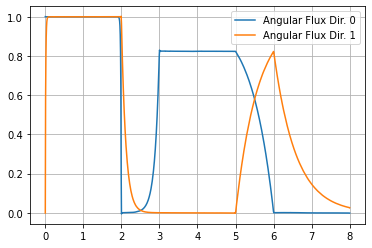

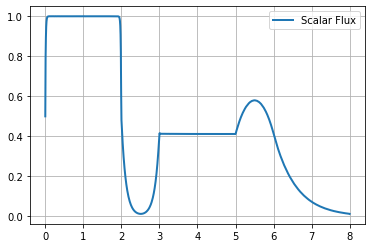

In [22]:
plt.figure()
plt.plot(x_mesh, predict_PiNN_dir(0, x_mesh), label='Angular Flux Dir. 0')
plt.plot(x_mesh, predict_PiNN_dir(1, x_mesh), label='Angular Flux Dir. 1')
plt.legend()
plt.grid()

plt.figure()
plt.plot(x_mesh, scalar_flux, label='Scalar Flux', linewidth=2.)
plt.legend()
plt.grid()

## Reed problem with scattering

### S2

In [ ]:
#############################
# Parameters
#############################
tf_epochs = 20 # Number of training epochs for the regression part
nt_epochs = 40 # Number of training epochs for the physics part
n_batches = 1 # External batches for Lagrange multipliers optimization
N_boundary = 50 # Number of samples per boundary
N_internal = 1000 # Number of internal collocation points

#############################
# Network srchitecture
#############################
dim = 1
layers = [dim] + 5*[64] + [1]

# Setting seeds
np.random.seed(17)
tf.random.set_seed(17)


##############################
# Parameters
##############################
# # Reference
sigt  = np.array([50., 5., 0., 1.,  1. ])
sigs  = np.array([ 0., 0., 0., 0.9, 0.9])
#sigs  = np.array([ 0., 0., 0., 0., 0.])
qext  = np.array([50., 0., 0., 1. , 0. ])
width = np.array([ 2., 1., 2., 1. , 2. ])

agg_width = np.cumsum(width)

snorder = 2
mu_q, w_q = np.polynomial.legendre.leggauss(snorder)
w_q /= np.sum(w_q)

##############################
# Domain
##############################
x_min, x_max = 0., 8.

# Boundaries (we create a few overlapping boundary points)
left   = np.linspace(x_min,x_min,N_boundary)
right  = np.linspace(x_max,x_max,N_boundary)

# Boundary conditions
# If Dirichlet: stores the values of the field boundary condition
# If Homogeneous or Robin: stores the values of the normals
u_bc_left  = np.array([left*0.])
u_bc_right = np.array([right*0.])

# Internal points
n_points = N_internal
x_mesh = np.linspace(x_min, x_max, n_points)

# Internal points training dict
points_dict = {}
points_dict['x_eq'] = x_mesh.flatten()

#################################
# Setting logger and optimizer
#################################
logger_pinn = {}
for i, _ in enumerate(mu_q):
  logger_pinn[i] = Logger(frequency=200)
  def error():
    return tf.reduce_sum((tf.square(dict_pinns[i].return_bc_loss()))).numpy()
  logger_pinn[i].set_error_fn(error)

#################################
# Setting up tf optimizer
#################################
tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

coupled_optimizer = {}
coupled_optimizer['nt_config'] = Struct()
coupled_optimizer['nt_config'].learningRate = 0.5
coupled_optimizer['nt_config'].maxIter = nt_epochs
coupled_optimizer['nt_config'].nCorrection = 50
coupled_optimizer['nt_config'].tolFun = 1.0 * np.finfo(float).eps
coupled_optimizer['batches'] = n_batches


#####################
# Creating PiNNS
#####################

def predict_PiNN_dir(i, x):
  return dict_pinns[i].predict(np.array([x]).T)

def compute_scalar_flux(dict_pinns):
  scalar_flux = np.zeros_like(x_mesh)
  for i, weight in enumerate(w_q):
    scalar_flux += predict_PiNN_dir(i, x_mesh) * weight
  return scalar_flux

def compute_scattering_vector():
  agg_width = np.cumsum(width)
  scattering_vector = x_mesh * 0.
  scattering_vector[x_mesh < agg_width[0]] = sigs[0]
  for i in range(1,len(sigs)):
    scattering_vector[(x_mesh >= agg_width[i-1]) & (x_mesh < agg_width[i])] = sigs[i]
  scattering_vector[(x_mesh >= agg_width[-1])] = sigs[-1]
  return scattering_vector

def compute_scattering_source(dict_pinns):
  return compute_scattering_vector() * compute_scalar_flux(dict_pinns) #/ 2.0

def add_scattering_sources(dict_pinns):
  scat_source = compute_scattering_source(dict_pinns)
  for i, _ in enumerate(mu_q):
    dict_pinns[i].add_coupled_variable('scat_source', scat_source)
    dict_pinns[i].add_external_reaction_term('scat_source', coef=1.0, ID=1)


dict_pinns = {}
for i, direction in enumerate(mu_q):

  #Creating PiNNs class
  if direction > 0:
    x_cord_bc = np.array([left])
    points_dict['x_bc'] = x_cord_bc.flatten()
    u_train_bc = u_bc_left.flatten()
  else:
    x_cord_bc = np.array([right])
    points_dict['x_bc'] = x_cord_bc.flatten()
    u_train_bc = u_bc_right.flatten()


  dict_pinns[i] = PhysicsInformedNN_ADR(layers=layers, optimizer=tf_optimizer, logger=logger_pinn[i], 
                                  dim = dim, points_dict=points_dict, 
                                  u_bc=u_train_bc, bc_type = 'Dirichlet',
                                  kernel_projection='Fourier',
                                  trainable_kernel=False)
  dict_pinns[i].gaussian_scale = 50.

  # Adding advection
  velocity = np.concatenate([[points_dict['x_eq']*0. + direction]], 1).T
  dict_pinns[i].add_coupled_variable('velocity', velocity)
  dict_pinns[i].add_advection_term('velocity')

  # Adding Power
  power = x_mesh * 0.
  power[x_mesh < agg_width[0]] = qext[0]
  power[(x_mesh >= agg_width[0]) & (x_mesh < agg_width[1])] = qext[1]
  power[(x_mesh >= agg_width[1]) & (x_mesh < agg_width[2])] = qext[2]
  power[(x_mesh >= agg_width[2]) & (x_mesh < agg_width[3])] = qext[3]
  power[(x_mesh >= agg_width[3])] = qext[4]
  power = tf.convert_to_tensor(power, dtype=dict_pinns[i].dtype)
  dict_pinns[i].add_coupled_variable('power', power)
  dict_pinns[i].add_external_reaction_term('power', coef=1.0, ID=0)

  # Adding self-reaction
  self_reaction_coef = x_mesh * 0. + 1.
  self_reaction_coef[x_mesh < agg_width[0]] = sigt[0]
  self_reaction_coef[(x_mesh >= agg_width[0]) & (x_mesh < agg_width[1])] = sigt[1]
  self_reaction_coef[(x_mesh >= agg_width[1]) & (x_mesh < agg_width[2])] = sigt[2]
  self_reaction_coef[(x_mesh >= agg_width[2]) & (x_mesh < agg_width[3])] = sigt[3]
  self_reaction_coef[(x_mesh >= agg_width[3])] = sigt[4]
  self_reaction_coef = tf.convert_to_tensor(self_reaction_coef, dtype=dict_pinns[i].dtype)
  dict_pinns[i].add_self_rection_term(self_reaction_coef)

# Scattering source iterations
iteration, max_iterations, error, tolerance = 0, 200, 1., 1e-4
current_epochs = nt_epochs
error_list, epochs_list = [], []
scalar_flux = tf.constant(0., dtype=dict_pinns[0].dtype)

while iteration <= max_iterations and error > tolerance:

  print('\n Iteration: {0} \n'.format(iteration))

  for i, _ in enumerate(mu_q):
    if iteration < 3:
      dict_pinns[i].fit(tf_epochs, coupled_optimizer, restart_model = True)
    else:
      dict_pinns[i].fit(tf_epochs, coupled_optimizer, restart_model = False)

  # Update scalar fluxes and compute error
  scalar_flux_old = scalar_flux * 1
  scalar_flux = compute_scalar_flux(dict_pinns)
  error = (tf.norm(scalar_flux - scalar_flux_old) / tf.norm(scalar_flux_old)).numpy()
  print('\n *************** \n Error: {0:.2e} \n ***************'.format(error))

  # Adaptive number of epochs
  error_list.append(error)
  epochs_list.append(current_epochs)

  if iteration >= 3:
    delta_error_current = abs(error_list[iteration] - error_list[iteration-1])
    delta_error_old = abs(error_list[iteration-1] - error_list[iteration-2])
    inflation_epochs_current = epochs_list[iteration] / epochs_list[iteration-1]
    inflation_epochs_old = epochs_list[iteration-1] / epochs_list[iteration-2]
    # Estimating current order of convergence
    error_delta = (delta_error_current) / (delta_error_old)
    error_delta -= np.log(abs(inflation_epochs_current/inflation_epochs_old))
    p = np.log(abs(error_delta)) / np.log(inflation_epochs_old + 1)
    # Estimating convergence log-ordinate
    c = abs(delta_error_current / (epochs_list[iteration-1]**p * (inflation_epochs_current**p)))
    # Estimating spectral radius
    sr = delta_error_old / delta_error_current
    # Estimating next source iteration error
    ne = abs(delta_error_current / sr)
    # Fixing new number of epochs
    current_epochs = int(max(min(min((ne / c) ** (1/p), current_epochs*1.2),1000),40))

  print('Computed new epochs {0}'.format(current_epochs))
  coupled_optimizer['nt_config'].maxIter = current_epochs

  add_scattering_sources(dict_pinns)

  iteration += 1


TensorFlow version: 2.6.0
Eager execution: True
GPU-accerelated: False
TensorFlow version: 2.6.0
Eager execution: True
GPU-accerelated: False

 Iteration: 0 


Training started
—— Starting Adam optimization ——
tf_epoch =      0  elapsed = 00:00  loss = 7.8833e+05  error = 3.2938e+00  
—— Starting LBFGS optimization ——
Working on batch 0
Training finished (epoch 60): duration = 00:05  error = 2.0621e-03  

Training started
—— Starting Adam optimization ——
tf_epoch =      0  elapsed = 00:05  loss = 8.1845e+05  error = 8.5707e-04  
—— Starting LBFGS optimization ——
Working on batch 0
Training finished (epoch 60): duration = 00:10  error = 4.0042e+01  

 *************** 
 Error: inf 
 ***************
Computed new epochs 40

 Iteration: 1 


Training started
—— Starting Adam optimization ——
tf_epoch =      0  elapsed = 00:11  loss = 7.8995e+05  error = 1.6166e-01  
—— Starting LBFGS optimization ——
Working on batch 0
Training finished (epoch 60): duration = 00:16  error = 1.6530e+01  

Trai

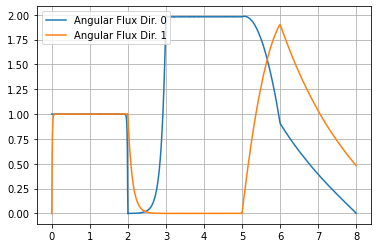

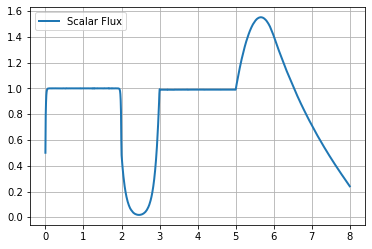

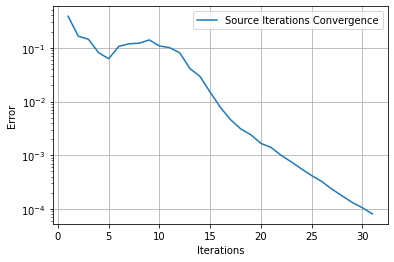

In [ ]:
plt.figure()
plt.plot(x_mesh, predict_PiNN_dir(0, x_mesh), label='Angular Flux Dir. 0')
plt.plot(x_mesh, predict_PiNN_dir(1, x_mesh), label='Angular Flux Dir. 1')
plt.legend()
plt.grid()

plt.figure()
plt.plot(x_mesh, scalar_flux, label='Scalar Flux', linewidth=2.)
plt.legend()
plt.grid()

plt.figure()
plt.semilogy(error_list, label='Source Iterations Convergence')
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.legend()
plt.grid()

### S4

In [ ]:
#############################
# Parameters
#############################
tf_epochs = 20 # Number of training epochs for the regression part
nt_epochs = 40 # Number of training epochs for the physics part
n_batches = 1 # External batches for Lagrange multipliers optimization
N_boundary = 50 # Number of samples per boundary
N_internal = 1000 # Number of internal collocation points

#############################
# Network srchitecture
#############################
dim = 1
layers = [dim] + 5*[64] + [1]

# Setting seeds
np.random.seed(17)
tf.random.set_seed(17)


##############################
# Parameters
##############################
# # Reference
sigt  = np.array([50., 5., 0., 1.,  1. ])
sigs  = np.array([ 0., 0., 0., 0.9, 0.9])
#sigs  = np.array([ 0., 0., 0., 0., 0.])
qext  = np.array([50., 0., 0., 1. , 0. ])
width = np.array([ 2., 1., 2., 1. , 2. ])

agg_width = np.cumsum(width)

snorder = 4
mu_q, w_q = np.polynomial.legendre.leggauss(snorder)
w_q /= np.sum(w_q)

##############################
# Domain
##############################
x_min, x_max = 0., 8.

# Boundaries (we create a few overlapping boundary points)
left   = np.linspace(x_min,x_min,N_boundary)
right  = np.linspace(x_max,x_max,N_boundary)

# Boundary conditions
# If Dirichlet: stores the values of the field boundary condition
# If Homogeneous or Robin: stores the values of the normals
u_bc_left  = np.array([left*0.])
u_bc_right = np.array([right*0.])

# Internal points
n_points = N_internal
x_mesh = np.linspace(x_min, x_max, n_points)

# Internal points training dict
points_dict = {}
points_dict['x_eq'] = x_mesh.flatten()

#################################
# Setting logger and optimizer
#################################
logger_pinn = {}
for i, _ in enumerate(mu_q):
  logger_pinn[i] = Logger(frequency=200)
  def error():
    return tf.reduce_sum((tf.square(dict_pinns[i].return_bc_loss()))).numpy()
  logger_pinn[i].set_error_fn(error)

#################################
# Setting up tf optimizer
#################################
tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

coupled_optimizer = {}
coupled_optimizer['nt_config'] = Struct()
coupled_optimizer['nt_config'].learningRate = 0.5
coupled_optimizer['nt_config'].maxIter = nt_epochs
coupled_optimizer['nt_config'].nCorrection = 50
coupled_optimizer['nt_config'].tolFun = 1.0 * np.finfo(float).eps
coupled_optimizer['batches'] = n_batches


#####################
# Creating PiNNS
#####################

def predict_PiNN_dir(i, x):
  return dict_pinns[i].predict(np.array([x]).T)

def compute_scalar_flux(dict_pinns):
  scalar_flux = np.zeros_like(x_mesh)
  for i, weight in enumerate(w_q):
    scalar_flux += predict_PiNN_dir(i, x_mesh) * weight
  return scalar_flux

def compute_scattering_vector():
  agg_width = np.cumsum(width)
  scattering_vector = x_mesh * 0.
  scattering_vector[x_mesh < agg_width[0]] = sigs[0]
  for i in range(1,len(sigs)):
    scattering_vector[(x_mesh >= agg_width[i-1]) & (x_mesh < agg_width[i])] = sigs[i]
  scattering_vector[(x_mesh >= agg_width[-1])] = sigs[-1]
  return scattering_vector

def compute_scattering_source(dict_pinns):
  return compute_scattering_vector() * compute_scalar_flux(dict_pinns) #/ 2.0

def add_scattering_sources(dict_pinns):
  scat_source = compute_scattering_source(dict_pinns)
  for i, _ in enumerate(mu_q):
    dict_pinns[i].add_coupled_variable('scat_source', scat_source)
    dict_pinns[i].add_external_reaction_term('scat_source', coef=1.0, ID=1)


dict_pinns = {}
for i, direction in enumerate(mu_q):

  #Creating PiNNs class
  if direction > 0:
    x_cord_bc = np.array([left])
    points_dict['x_bc'] = x_cord_bc.flatten()
    u_train_bc = u_bc_left.flatten()
  else:
    x_cord_bc = np.array([right])
    points_dict['x_bc'] = x_cord_bc.flatten()
    u_train_bc = u_bc_right.flatten()


  dict_pinns[i] = PhysicsInformedNN_ADR(layers=layers, optimizer=tf_optimizer, logger=logger_pinn[i], 
                                  dim = dim, points_dict=points_dict, 
                                  u_bc=u_train_bc, bc_type = 'Dirichlet',
                                  kernel_projection='Fourier',
                                  trainable_kernel=False)
  dict_pinns[i].gaussian_scale = 50.

  # Adding advection
  velocity = np.concatenate([[points_dict['x_eq']*0. + direction]], 1).T
  dict_pinns[i].add_coupled_variable('velocity', velocity)
  dict_pinns[i].add_advection_term('velocity')

  # Adding Power
  power = x_mesh * 0.
  power[x_mesh < agg_width[0]] = qext[0]
  power[(x_mesh >= agg_width[0]) & (x_mesh < agg_width[1])] = qext[1]
  power[(x_mesh >= agg_width[1]) & (x_mesh < agg_width[2])] = qext[2]
  power[(x_mesh >= agg_width[2]) & (x_mesh < agg_width[3])] = qext[3]
  power[(x_mesh >= agg_width[3])] = qext[4]
  power = tf.convert_to_tensor(power, dtype=dict_pinns[i].dtype)
  dict_pinns[i].add_coupled_variable('power', power)
  dict_pinns[i].add_external_reaction_term('power', coef=1.0, ID=0)

  # Adding self-reaction
  self_reaction_coef = x_mesh * 0. + 1.
  self_reaction_coef[x_mesh < agg_width[0]] = sigt[0]
  self_reaction_coef[(x_mesh >= agg_width[0]) & (x_mesh < agg_width[1])] = sigt[1]
  self_reaction_coef[(x_mesh >= agg_width[1]) & (x_mesh < agg_width[2])] = sigt[2]
  self_reaction_coef[(x_mesh >= agg_width[2]) & (x_mesh < agg_width[3])] = sigt[3]
  self_reaction_coef[(x_mesh >= agg_width[3])] = sigt[4]
  self_reaction_coef = tf.convert_to_tensor(self_reaction_coef, dtype=dict_pinns[i].dtype)
  dict_pinns[i].add_self_rection_term(self_reaction_coef)

# Scattering source iterations
iteration, max_iterations, error, tolerance = 0, 200, 1., 1e-4
current_epochs = nt_epochs
error_list, epochs_list = [], []
scalar_flux = tf.constant(0., dtype=dict_pinns[0].dtype)

while iteration <= max_iterations and error > tolerance:

  print('\n Iteration: {0} \n'.format(iteration))

  for i, _ in enumerate(mu_q):
    if iteration < 3:
      dict_pinns[i].fit(tf_epochs, coupled_optimizer, restart_model = True)
    else:
      dict_pinns[i].fit(tf_epochs, coupled_optimizer, restart_model = False)

  # Update scalar fluxes and compute error
  scalar_flux_old = scalar_flux * 1
  scalar_flux = compute_scalar_flux(dict_pinns)
  error = (tf.norm(scalar_flux - scalar_flux_old) / tf.norm(scalar_flux_old)).numpy()
  print('\n *************** \n Error: {0:.2e} \n ***************'.format(error))

  # Adaptive number of epochs
  error_list.append(error)
  epochs_list.append(current_epochs)

  if iteration >= 3:
    delta_error_current = abs(error_list[iteration] - error_list[iteration-1])
    delta_error_old = abs(error_list[iteration-1] - error_list[iteration-2])
    inflation_epochs_current = epochs_list[iteration] / epochs_list[iteration-1]
    inflation_epochs_old = epochs_list[iteration-1] / epochs_list[iteration-2]
    # Estimating current order of convergence
    error_delta = (delta_error_current) / (delta_error_old)
    error_delta -= np.log(abs(inflation_epochs_current/inflation_epochs_old))
    p = np.log(abs(error_delta)) / np.log(inflation_epochs_old + 1)
    # Estimating convergence log-ordinate
    c = abs(delta_error_current / (epochs_list[iteration-1]**p * (inflation_epochs_current**p)))
    # Estimating spectral radius
    sr = delta_error_old / delta_error_current
    # Estimating next source iteration error
    ne = abs(delta_error_current / sr)
    # Fixing new number of epochs
    current_epochs = int(max(min(min((ne / c) ** (1/p), current_epochs*1.2),1000),40))

  print('Computed new epochs {0}'.format(current_epochs))
  coupled_optimizer['nt_config'].maxIter = current_epochs

  add_scattering_sources(dict_pinns)

  iteration += 1


TensorFlow version: 2.6.0
Eager execution: True
GPU-accerelated: False
TensorFlow version: 2.6.0
Eager execution: True
GPU-accerelated: False
TensorFlow version: 2.6.0
Eager execution: True
GPU-accerelated: False
TensorFlow version: 2.6.0
Eager execution: True
GPU-accerelated: False

 Iteration: 0 


Training started
—— Starting Adam optimization ——
tf_epoch =      0  elapsed = 00:00  loss = 7.6078e+05  error = 4.7464e-03  
—— Starting LBFGS optimization ——
Working on batch 0
Training finished (epoch 60): duration = 00:05  error = 2.5122e+01  

Training started
—— Starting Adam optimization ——
tf_epoch =      0  elapsed = 00:05  loss = 7.8226e+05  error = 2.1197e-01  
—— Starting LBFGS optimization ——
Working on batch 0
Training finished (epoch 60): duration = 00:11  error = 2.0505e+01  

Training started
—— Starting Adam optimization ——
tf_epoch =      0  elapsed = 00:11  loss = 8.0435e+05  error = 5.7226e-01  
—— Starting LBFGS optimization ——
Working on batch 0
Training finished (ep

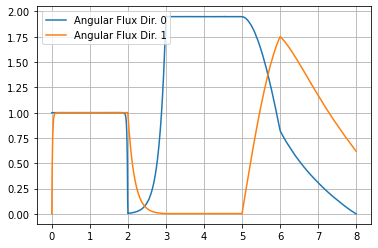

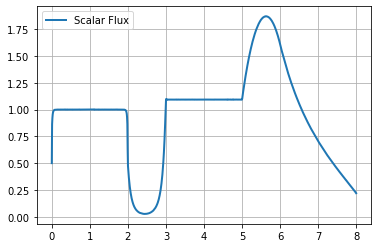

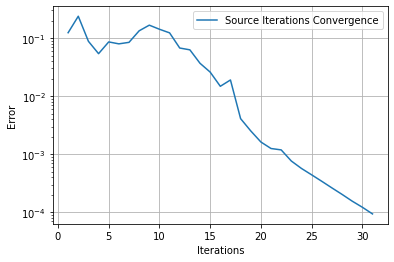

In [ ]:
plt.figure()
plt.plot(x_mesh, predict_PiNN_dir(0, x_mesh), label='Angular Flux Dir. 0')
plt.plot(x_mesh, predict_PiNN_dir(3, x_mesh), label='Angular Flux Dir. 1')
plt.legend()
plt.grid()

plt.figure()
plt.plot(x_mesh, scalar_flux, label='Scalar Flux', linewidth=2.)
plt.legend()
plt.grid()

plt.figure()
plt.semilogy(error_list, label='Source Iterations Convergence')
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.legend()
plt.grid()

Ideas:

- Adding TVD schemes
- Optimizing the architecture and hyper-parameters of the PiNN via Bayesian Optimization
- Setting the collocation points of the training grid via an optimization metric (?)